In [225]:
from torch.utils.data import Dataset
from torchvision import transforms

In [226]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install torchmetrics
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision import models
import torch.nn as nn

In [284]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe):
        super(ChestXRayDataset, self).__init__()
        self.dataframe = dataframe

        # Fill in __init__() here

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(f'content/'+path).convert('RGB')
        conv_tensor = transforms.ToTensor()
        images = conv_tensor(image)
        if 'distance_mm' in self.dataframe.columns:
          labels = torch.tensor(self.dataframe.iloc[idx]['distance_mm'])
          return path, images, labels
        return path, images

In [285]:
df = pd.read_csv('content/distances.csv',index_col=0)
all_data = ChestXRayDataset(dataframe=df)

In [286]:
load_model = models.alexnet(pretrained=True)
load_model._modules['classifier'][-1] = nn.Linear(4096, 1, bias=True)
load_model.classifier.add_module('7', nn.ReLU(inplace=True))
load_model.load_state_dict(torch.load('content/checkpoints/epoch_13.ckpt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [287]:
all_loader = torch.utils.data.DataLoader(dataset=all_data, batch_size=1, shuffle=True)

In [288]:
load_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [290]:
import PIL

In [484]:
path, pil_img, label = next(iter(all_loader))

In [485]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
normed_torch_img = normed_torch_img.squeeze(1)

In [486]:
normed_torch_img.size()

torch.Size([1, 3, 224, 224])

In [487]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid, save_image

In [488]:
gr = dict(model_type='alexnet', arch=load_model, layer_name='classifier')
gradcam = GradCAM.from_config(**gr)
gradcam_pp = GradCAMpp.from_config(**gr)

In [489]:
images = []
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, torch_img)

mask_pp, _ = gradcam_pp(normed_torch_img)
heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

images.extend([torch_img.cpu().squeeze(), heatmap, heatmap_pp, result, result_pp])
grid_image = make_grid(images, nrow=5)


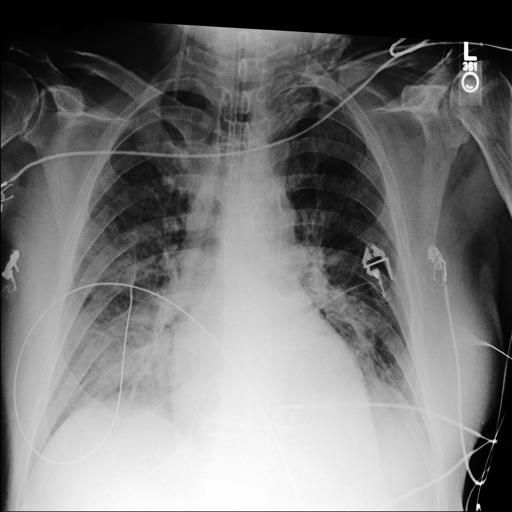

expected:  tensor([40.], dtype=torch.float64)
output:  tensor([[42.4923]], grad_fn=<ReluBackward0>)


In [490]:
display(Image.open(f'content/'+path[0]))
print('expected: ', label)
print('output: ', load_model(pil_img))

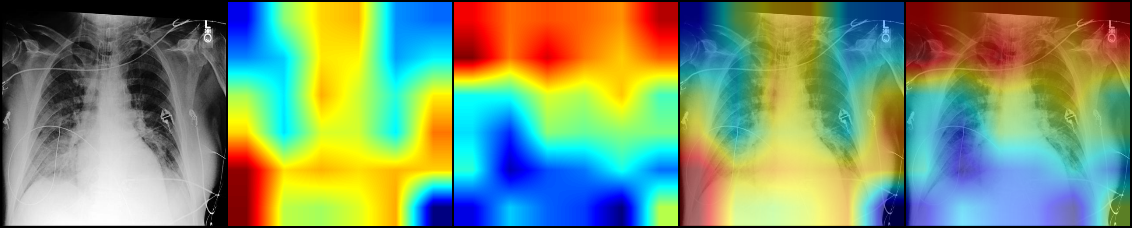

In [491]:
transforms.ToPILImage()(grid_image)

In [413]:
# what is pp?
# what layer should it be done on?

In [436]:
resnet50_exp6 = models.resnet50(pretrained=True)
n_features = resnet50_exp6.fc.in_features
resnet50_exp6.fc = nn.Sequential(
    nn.Linear(n_features, n_features),
    nn.Dropout(p=0.5),
    nn.Linear(n_features, n_features),
    nn.ReLU(),
    nn.Linear(n_features, 1)
)

model_exp6 = torch.load("/Users/shreeyachand/Downloads/resnet50_tl_exp_6_epoch_28.pth", map_location=torch.device('cpu'))
resnet50_exp6.load_state_dict(model_exp6["model_state_dict"])

<All keys matched successfully>

In [437]:
resnet50_exp6.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [494]:
gr = dict(model_type='resnet', arch=resnet50_exp6, layer_name='layer4')
gradcam = GradCAM.from_config(**gr)
gradcam_pp = GradCAMpp.from_config(**gr)

In [495]:
images = []
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, torch_img)

mask_pp, _ = gradcam_pp(normed_torch_img)
heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

images.extend([torch_img.cpu().squeeze(), heatmap, heatmap_pp, result, result_pp])
grid_image = make_grid(images, nrow=5)

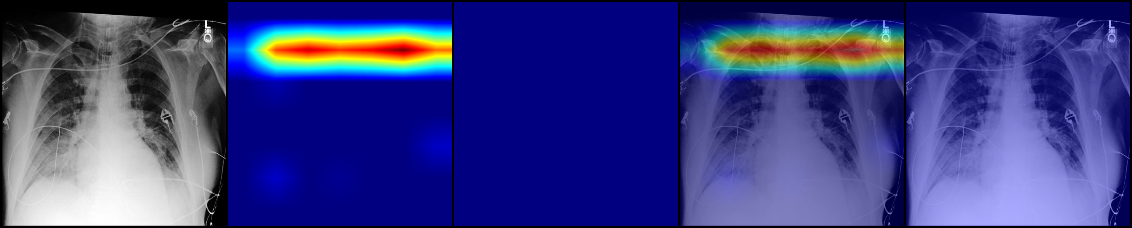

In [496]:
transforms.ToPILImage()(grid_image)